# MSCF 46982 Market Microstructure and Algorithmic Trading

Fall 2025 Mini 2

Advanced NYSE Daily TAQ Queries

Copyright &copy; 2025 Nick Psaris. All Rights Reserved

# TOC
- [Initialize](#Initialize)
- [Attributes](#Attributes)
- [Joins](#Joins)
- [Left Join](#Left-Join)
- [Union Join](#Union-Join)
- [Inner Join](#Inner-Join)
- [Lee-Ready](#Lee-Ready)
- [Asof Join](#Asof-Join)
- [Order Book Imbalance](#Order-Book-Imbalance)
- [Amihud Illiquidity](#Amihud-Illiquidity)
- [Kyle's Lambda](#Kyle's-Lambda)
- [Least Squares Regression](#Least-Squares-Regression)
- [Market Impact](#Market-Impact)
- [Trading Costs](#Trading-Costs)
- [Tick Size Dynamics](#Tick-Size-Dynamics)
- [Tick Size Pilot Program](#Tick-Size-Pilot-Program)
- [Intelligent Ticks](#Intelligent-Ticks)
- [Optimal Tick Size](#Optimal-Tick_Size)
- [Reg NMS Changes](#Reg-NMS-Changes)
- [Window Join](#Window-Join)
- [Trade Markouts](#Trade-Markouts)

# Initialize
- We start by initializing the number of rows and columns displayed
- Connecting to the NYSE Daily TAQ database
- Downloading a few tables

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


In [2]:
\c 15 100
/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf


`:/Users/nick/cmu_userpass.txt


In [3]:
%%py
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]


## Recover trade, nbbo and security master tables

In [4]:
syms:`BAC
dt:2020.02.05
trades:{[dt;syms]select from trade where date=dt,sym in syms, null cond}
t:h (trades;dt;syms)
nbbos:{[dt;syms]select from nbbo where date=dt,sym in syms}
n:h(nbbos;dt;syms)
m:h"mas"

In [5]:
roll:{2f*sqrt neg x scov prev x-:prev x}
bar:0D01
vwap:select vwap:size wavg price,sum size,esprd:roll price,nt:count i by bar xbar time from t
n:update mid:.5*bid+ask,sprd:ask-bid from n where bsize>0,asize>0
n:update wmid:(bsize;asize) wavg (ask;bid) from n where bsize>0,asize>0
n:update durn:deltas[first time;time] from n
twap:select durn wavg prev wmid,durn wavg sprd,nq:count i by bar xbar time from n

# Attributes

- Beyond just fast computations on very large datasets, kdb+ joins
  data very efficiently
- But to achieve full performance, we need to dive into attributes
- Instead of creating different datastructures, attributes are used to
  augment efficiently stored vectors
- There are four attributes: `` `s``,`` `u``,`` `p``,`` `g``
- Sorry, I've been told there is no more room in the language for more
- Deleting rows from a list (or dictionary or table) will remove all
  attributes -- this is therefore not a common practice in kdb+
- It is important to understand attributes and their performance
  enhancing effects


## Sorted
- The `#` operator is used to apply attributes to lists
- The `` `s`` attribute takes up no memory, but checks and flags the
  list as available for binary search


In [6]:
`s#x:1 2 3 4;
x

`s#1 2 3 4


In [7]:
meta select from select by sym from m

c    | t f a
-----| -----
sym  | s   s
cusip| s    
wi   | b    
date | d    
name | s    
ex   | c    
uot  | i    


## Unique
- The `` `u`` attribute checks that a list only has **unique**
  elements
- An internal hashmap is then created to store the location of each
  value
- It is useful for long lists of unique elements (querying short lists
  would be slowed down by computing the hashing function)
- Kdb+ politely informs you if a list is not actually unique

In [8]:
u:`u#0 0 1 1 2 2

QError: u-fail

## Parted
- The `` `p`` attribute is used when there is **ordered repetition**
  in values
- An internal hashmap is created to store a pair of values for each
  unique value: the start location and the number of values
- All tables within a typical Kdb+ Historical Database (HDB) have the
  `` `p`` attribute set
- This is because the data is sorted before being saved

In [9]:
h "meta trade"

c    | t f a
-----| -----
date | d    
sym  | s   p
time | n    
price| f    
size | i    
stop | b    
cond | c    
ex   | c    


## Grouped
- The `` `g`` attribute is used when there is **unordered repetition**
  in values
- An internal hashmap is created to store the location of each unique
  value
- Takes up the most memory among all the attributes
- Rarely used in HDBs because we have the ability to sort the data
  before saving
- Is, however, common in Realtime Databases (RDBs)
- Because want fast query performance with random arrival order

In [10]:
r:5
rdb:update `g#sym,`s#time from ([]sym:upper r?`1;time:.z.p+til r;price:r?10f;size:r?10i;exch:r?.Q.A)
meta rdb

c    | t f a
-----| -----
sym  | s   g
time | p   s
price| f    
size | i    
exch | c    


# Joins

- Analysis is enhanced when different data sets are combined
- Some joins require exact matches: daily reference data
- Other joins are used for fuzzy matches: most recent quote at the
  time of a trade
- And yet other joins are used for complex aggregations: trailing 5
  minute VWAP of a trade
- In order of popularity, the joins are:
  `lj`,`aj`,`uj`,`ij`,`wj`,`pj`,`ej`
- There are "filled" versions of a few of these as well
  `ljf`,`ajf`,`ujf`,`ijf`


# Left Join
- The left-join `lj` operator combines two tables based on columns
  with equal values
- The key of the right table will be used to join against the left
  table (which does not need to be keyed)
- The key columns must exist in the right table
- Unjoinable rows will **contain null values**

In [11]:
(0!twap) lj vwap

time                 wmid     sprd        nq     vwap     size    esprd       nt   
-----------------------------------------------------------------------------------
0D04:00:00.000000000 33.92149 0.2423274   948                                      
0D05:00:00.000000000 34.07983 0.121341    128                                      
0D06:00:00.000000000 33.9959  0.1287954   546                                      
0D07:00:00.000000000 33.96912 0.04303029  133                                      
0D08:00:00.000000000 34.0958  0.03366101  541                                      
0D09:00:00.000000000 34.16434 0.0191556   273015 34.21821 3784805 0.00390106  10733
0D10:00:00.000000000 34.48654 0.009993371 628826 34.48782 8016641 0.003384948 22874
0D11:00:00.000000000 34.64501 0.009991259 298319 34.63876 5220128 0.003501161 13144
0D12:00:00.000000000 34.75398 0.009998482 182907 34.75687 4158773 0.003305439 10483
0D13:00:00.000000000 34.69341 0.009998117 143897 34.69307 2783216 0.00377716

# Inner Join
- The inner-join `ij` operator combines two tables based on columns
  with equal values
- The key of the right table will be used to join against the left
  table (which does not need to be keyed)
- The key columns must exist in the right table
- Unjoinable rows will contain **not be returned**


In [12]:
(0!twap) ij vwap

time                 wmid     sprd        nq     vwap     size    esprd       nt   
-----------------------------------------------------------------------------------
0D09:00:00.000000000 34.16434 0.0191556   273015 34.21821 3784805 0.00390106  10733
0D10:00:00.000000000 34.48654 0.009993371 628826 34.48782 8016641 0.003384948 22874
0D11:00:00.000000000 34.64501 0.009991259 298319 34.63876 5220128 0.003501161 13144
0D12:00:00.000000000 34.75398 0.009998482 182907 34.75687 4158773 0.003305439 10483
0D13:00:00.000000000 34.69341 0.009998117 143897 34.69307 2783216 0.003777167 7224 
0D14:00:00.000000000 34.65867 0.009994297 159344 34.6587  3210199 0.00381125  8081 
0D15:00:00.000000000 34.69307 0.00999055  255534 34.68563 5992344 0.003418224 15305


# Union Join

- The union-join `uj` operator combines two tables based on columns
  with equal values
- The key of the right table will be used to join against the left
  table **and** the key of the left table will be used to join against the
  right table
- Unjoinable rows from the left operand will be appended to the
  resulting table which will probably need to be resorted!


In [13]:
vwap uj twap

time                | vwap     size    esprd       nt    wmid     sprd        nq    
--------------------| --------------------------------------------------------------
0D09:00:00.000000000| 34.21821 3784805 0.00390106  10733 34.16434 0.0191556   273015
0D10:00:00.000000000| 34.48782 8016641 0.003384948 22874 34.48654 0.009993371 628826
0D11:00:00.000000000| 34.63876 5220128 0.003501161 13144 34.64501 0.009991259 298319
0D12:00:00.000000000| 34.75687 4158773 0.003305439 10483 34.75398 0.009998482 182907
0D13:00:00.000000000| 34.69307 2783216 0.003777167 7224  34.69341 0.009998117 143897
0D14:00:00.000000000| 34.6587  3210199 0.00381125  8081  34.65867 0.009994297 159344
0D15:00:00.000000000| 34.68563 5992344 0.003418224 15305 34.69307 0.00999055  255534
0D04:00:00.000000000|                                    33.92149 0.2423274   948   
0D05:00:00.000000000|                                    34.07983 0.121341    128   
0D06:00:00.000000000|                                    33.9959 

# Lee-Ready
## Buyer vs Seller Initiated Volume
- Tick test
- [Lee and Ready (1991)][LR]
- Mark and Ready (1992) doesn't include tick-test
- Ellis, O’Hara, and Michaely (2000) use tick-test for all trades
  within bid/ask
- Odders-White (2000) use order flow information, assume last order is
  the 'initiated' side

All estimates have documented biases, but we implement the LR
algorithm as a demonstration

[LR]: https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1540-6261.1991.tb02683.x "Lee and Ready (1991)"


## The Algorithm
- If trade is closer to bid, it is seller initiated
- Else if trade is closer to ask, it is buyer initiated
- Else:
  - If last tick was an uptick, it is buyer initiated
  - Else it was seller initiated
  

## Load the valid trades and label up/down ticks
- The `prev` operator also has an optional first parameter which can
  be used instead of null
- The `signum` operator returns -1, 0 or 1 depending on the sign of
  its argument
- The `fills` operator runs through a vector and fills forward the
  last non null value across nulls


In [14]:
taq:select date,sym,time,price,size from t where null cond / throw away trades with condition codes
taq:update tick:fills -1 0N 1@1+signum price-prev[first price;price] from taq / determine up/down tick
5000_taq

date       sym time                 price   size tick
-----------------------------------------------------
2020.02.05 BAC 0D09:42:21.642363247 34.13   100  -1  
2020.02.05 BAC 0D09:42:23.220811826 34.1343 800  1   
2020.02.05 BAC 0D09:42:23.584349690 34.135  200  1   
2020.02.05 BAC 0D09:42:23.584382808 34.14   2784 1   
2020.02.05 BAC 0D09:42:23.584432656 34.14   500  1   
2020.02.05 BAC 0D09:42:23.584432656 34.14   100  1   
2020.02.05 BAC 0D09:42:23.584447946 34.14   100  1   
2020.02.05 BAC 0D09:42:23.585034413 34.14   200  1   
2020.02.05 BAC 0D09:42:23.585202009 34.14   400  1   
2020.02.05 BAC 0D09:42:23.585470018 34.14   100  1   
..


# Asof Join
- Finding the active nbbo quote at the time of trade is an example of
  where Kdb+ really shines
- The asof join `aj` operator finds the most recent (based on time or
  other "integer value") record for a shared key
- It uses the `bin` operator, like `asof`, but doesn't force us to
  piece the table back together
- All join keys except the last will be used for exact matches (just
  like `lj`)
- The last join key will be used with the `bin` operator on the
  filtered rows to find the most recent record


In [15]:
10#taq:aj[`time;taq] select time,bsize,bid,ask,asize,mid,wmid from n

date       sym time                 price size tick bsize bid   ask   asize mid    wmid    
-------------------------------------------------------------------------------------------
2020.02.05 BAC 0D09:30:01.935330666 34.09 153       1     34.08 34.11 5     34.095 34.085  
2020.02.05 BAC 0D09:30:02.739572077 34.07 100  -1   8     34.06 34.09 1     34.075 34.08667
2020.02.05 BAC 0D09:30:05.610707976 34.1  114  1    1     34.09 34.11 1     34.1   34.1    
2020.02.05 BAC 0D09:30:10.679172558 34.07 100  -1   39    34.07 34.1  2     34.085 34.09854
2020.02.05 BAC 0D09:30:10.684007131 34.07 100  -1   38    34.07 34.09 3     34.08  34.08854
2020.02.05 BAC 0D09:30:10.684596467 34.07 262  -1   34    34.07 34.09 5     34.08  34.08744
2020.02.05 BAC 0D09:30:10.685644990 34.08 100  1    29    34.07 34.09 5     34.08  34.08706
2020.02.05 BAC 0D09:30:10.685658125 34.07 400  -1   29    34.07 34.09 5     34.08  34.08706
2020.02.05 BAC 0D09:30:10.695135414 34.07 100  -1   29    34.07 34.09 1     34.0

# Trade and Quote Query
- Since we only selected the trades for one symbol, we don't need to
  specify the sym column, but joins across multiple symbols would
  specify ``aj[`sym`time;;]``
- Always make sure the last column is the time and the first column
  has a `` `p`` or `` `g`` attribute on it
- Since we pulled all the data back to our local q process, we limited
  the nbbo table to just the rows we wanted.  But if we perform the
  ``aj`` on the server, **it is much more efficient to remove all
  filters from the quote/nbbo query beyond ``date``**.  Filtering on
  sym (or time, etc) copies the data from disk in RAM and drops the ``
  `p`` attribute.  Skipping the filters allows q to memory-map the
  data from disk and maintains the `` `p`` attribute


In [16]:
taqqry:{[s;dt]
 t:select from trade where date = dt, sym in s; / filter on symbols!
 t:aj[`sym`time;t] select sym,time,bid,ask from nbbo where date = dt; / don't filter on symbols!
 t}
h (taqqry;`BAC`TSLA;2020.02.03)

date       sym time                 price size stop cond ex bid   ask  
-----------------------------------------------------------------------
2020.02.03 BAC 0D04:00:00.025372155 33.01 9    0    T    P             
2020.02.03 BAC 0D04:00:29.450000693 33.01 65   0    T    P  32.96 33.2 
2020.02.03 BAC 0D04:05:00.744997751 32.96 19   0    T    P  32.9  33.2 
2020.02.03 BAC 0D04:08:07.655030242 32.96 59   0    T    P  32.9  33.2 
2020.02.03 BAC 0D04:08:28.100783594 32.92 300  0    T    P  32.9  33.2 
2020.02.03 BAC 0D04:22:27.582913425 32.98 224  0    T    P  33    33.04
2020.02.03 BAC 0D04:22:27.582941646 32.99 100  0    T    P  33    33.04
2020.02.03 BAC 0D04:22:27.582999341 33    110  0    F    P  32.9  33.04
2020.02.03 BAC 0D04:22:27.675961585 33    66   0    F    P  32.86 33.04
2020.02.03 BAC 0D04:27:44.668300003 32.98 100  0    T    P  32.86 32.99
..


# Trade vs Quote Timestamps
- We are using nanosecond precision timestamps
- The alternative is to use the exchange provided (monotonically
  increasing) sequence number
- Is there a delay we should apply to the quote times to get them to
  be more in-line with the trade times?
- Is that different between exchanges?
- Notice how conditional statements are rendered as vectorized
  mathematical computations


In [17]:
\c 20 200
taq:update side:?[price>mid;1;?[price<mid;-1;tick]] from taq
/taq:update bqty:size from taq where side > 0
/taq:update sqty:size from taq where side < 0
taq:update bqty:size*side>0,sqty:size*side<0 from taq
taq

date       sym time                 price size tick bsize bid   ask   asize mid    wmid     side bqty sqty
----------------------------------------------------------------------------------------------------------
2020.02.05 BAC 0D09:30:01.935330666 34.09 153       1     34.08 34.11 5     34.095 34.085   -1   0    153 
2020.02.05 BAC 0D09:30:02.739572077 34.07 100  -1   8     34.06 34.09 1     34.075 34.08667 -1   0    100 
2020.02.05 BAC 0D09:30:05.610707976 34.1  114  1    1     34.09 34.11 1     34.1   34.1     1    114  0   
2020.02.05 BAC 0D09:30:10.679172558 34.07 100  -1   39    34.07 34.1  2     34.085 34.09854 -1   0    100 
2020.02.05 BAC 0D09:30:10.684007131 34.07 100  -1   38    34.07 34.09 3     34.08  34.08854 -1   0    100 
2020.02.05 BAC 0D09:30:10.684596467 34.07 262  -1   34    34.07 34.09 5     34.08  34.08744 -1   0    262 
2020.02.05 BAC 0D09:30:10.685644990 34.08 100  1    29    34.07 34.09 5     34.08  34.08706 1    100  0   
2020.02.05 BAC 0D09:30:10.685658125 3

# Order Book Imbalance

In [18]:
.pykx.set[`i] .pykx.topd select sum bqty, sum sqty by imbalance:.01 xbar bsize%bsize+asize from taq

<Axes: title={'center': 'volume as a function of book imbalance'}, xlabel='imbalance'>

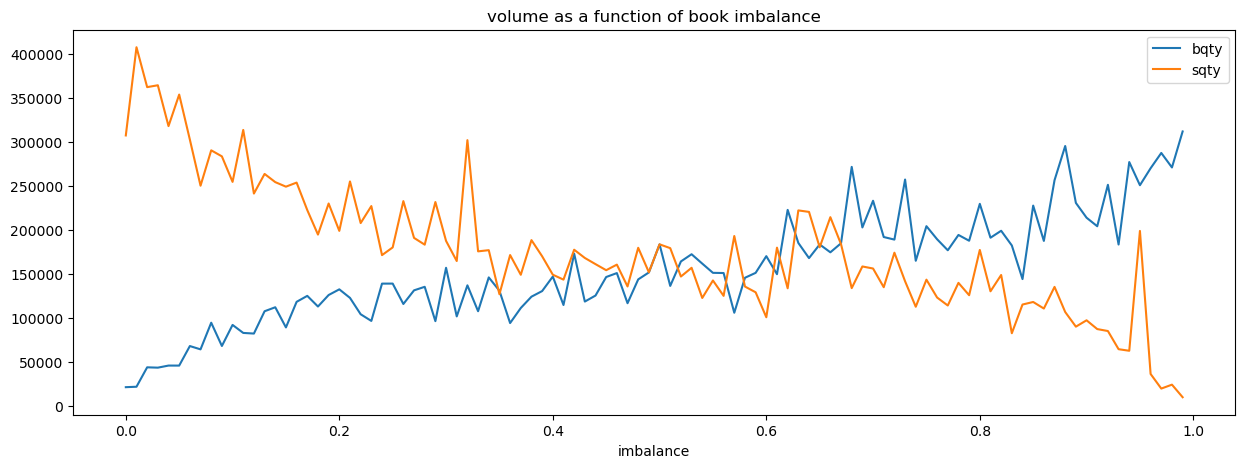

In [19]:
%%py
i.plot(title='volume as a function of book imbalance')


# Trading within, on and outside the bid/ask spread
- How much volume is traded:
  + -2: below the bid
  + -1: on the bid
  +  0: within the bid/ask
  +  1: on the ask
  +  2: above the ask

In [20]:
update pct:n%sum n from select n:count i by signum[price-bid]+signum[price-ask] from taq

price| n     pct        
-----| -----------------
-2   | 506   0.005760211
-1   | 27836 0.3168799  
0    | 37680 0.4289422  
1    | 21399 0.2436023  
2    | 423   0.004815354


# [Amihud Illiquidity](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1295244)
- Illiquidity is measured as 
$$
\text{ILLIQ}_i = \frac{1}{D_i}\sum_{t=0}^{D_i}\frac{\left| r_{it} \right|}{\text{DVOL}_{it}}
$$
where:
  + $D_i$ is the number of days for stock $i$
  + $r_{it}$ is the return for stock $i$ on day $t$
  + $\text{DVOL}_{it}$ is the dollar volume for stock $i$ on day $t$
- The Amihud measure is one of the most popular (il)liquidity measures
- [Amihud's research][AMIHUD] shows that stocks with a high
illiquidity measure have higher expected returns > This paper shows
that over time, expected market illiquidity positively affects ex-ante
stock excess return, suggesting that expected stock excess return
partly represents an *illiquidity premium*.
- But can this excess return be captured in the presence of market
  impact costs?
- What type of institutions can hold illiquid stocks?

[AMIHUD]: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1295244

## Computing the Amihud illiquidity
- Remember that the `price` column stores the daily notional traded


In [21]:
a:h "select[<amihud] amihud:avg abs[log close%prev close]%price,dvol:1e-9*avg price by sym from daily"
10#select from a where amihud>0

sym | amihud       dvol     
----| ----------------------
SPY | 2.9357e-13   37.51558 
BIL | 6.347482e-13 0.2395389
HYG | 8.210386e-13 3.630431 
LQD | 1.09749e-12  2.232965 
MINT| 1.112227e-12 0.1579097
QQQ | 1.25423e-12  11.04185 
SHV | 1.337952e-12 0.3474289
AMZN| 1.36946e-12  10.52811 
AAPL| 1.413021e-12 13.00502 
AGG | 1.69571e-12  1.285694 


# Kyle's Lambda

[Kyle, A. S. (1985)][]. Continuous Auctions and Insider Trading. Econometrica, 53(6), 1315–1335.

[Kyle, A. S. (1985)]: https://doi.org/10.2307/1913210 "Kyle, A. S. (1985)"

- Price impact estimation follows:
$$
\Delta m_t = \mu + \lambda q_t + \epsilon_t
$$

where:
  - $\Delta m_t$ is the change in mid price over time $t$
  - $\mu$ is the stock trend/drift
  - $q_t$ is the order imbalance (total buy - sell orders)
- Intuition is that for a given traded volume, a stock with a high
  $\lambda$ results in more impact
- Liquidity is decreasing in $\lambda$.  i.e., liquidity is a function
  of $\frac{1}{\lambda}$
- Assuming short time horizons, stock drift can be ignored
- $\lambda$ can be estimated by regressing price changes against
  quantity traded $\lambda=\frac{\Delta m_t}{q_t}$


## Computing Kyle's lambda

In [22]:
b:0D00:05 / bin size
m:0!select qty:"f"$sum size*side,open:"f"$first mid, close:"f"$last mid by b xbar time from taq
show m:update lambda:dpx%qty from delete open, close from update dpx:deltas[first open;close] from m

time                 qty     dpx   lambda       
------------------------------------------------
0D09:30:00.000000000 -59438  0.1   -1.682425e-06
0D09:35:00.000000000 -18542  -0.02 1.078632e-06 
0D09:40:00.000000000 3779    -0.02 -5.292405e-06
0D09:45:00.000000000 -23827  0.13  -5.455995e-06
0D09:50:00.000000000 -76233  -0.01 1.311768e-07 
0D09:55:00.000000000 -39916  0.02  -5.010522e-07
0D10:00:00.000000000 -99148  0.14  -1.41203e-06 
0D10:05:00.000000000 -168246 0.03  -1.783103e-07
0D10:10:00.000000000 -164295 0.02  -1.217322e-07
0D10:15:00.000000000 -120577 0.03  -2.488037e-07
0D10:20:00.000000000 13492   0.07  5.18826e-06  
0D10:25:00.000000000 16091   -0.11 -6.83612e-06 
0D10:30:00.000000000 -110696 0.04  -3.6135e-07  
0D10:35:00.000000000 -25207  -0.06 2.380291e-06 
0D10:40:00.000000000 39903   0.06  1.503646e-06 
..


# Least Squares Regression
## In Q
- The `mmu` operator is matrix multiplication
- The `lsq` operator can be thought of as matrix divide
- If `x = w mmu y`, then `w = x lsq y`
- Note that matrix operations **must** be performed on (f)loats, not r(e)als
- So, if `dpx:lambda mmu qty`, then `lambda:dpx lsq qty`

In [23]:
(1 2 3f;2 3 4f)

1 2 3
2 3 4


## Assuming y-intercept is 0

- With two vectors, we fit the slope with y=0 intercept

In [24]:
enlist[m`dpx] lsq enlist m`qty

1.964697e-08


## Fitting the y-intercept
- We can also fit the y-intersept (the drift) by prepending the qty
  matrix with a vector of 1s
- This is also referred to as adding a bias term

In [25]:
show fit:enlist[m`dpx] lsq (count[m]#1f;m`qty)
show predict:fit mmu (count[m]#1f;m`qty)

0.009536687 6.53367e-08
0.005653204 0.008325214 0.009783595 0.00797991 0.004555875 0.006928708 0.003058684 -0.001455951 -0.001197806 0.001658584 0.01041821 0.01058802 0.002304176 0.007889745 0.01214382 0.007907125 0.00608..


## In Python

- First copy the data from the q process into python

In [26]:
.pykx.set[`dpx] .pykx.tonp m`dpx
.pykx.set[`qty] .pykx.tonp m`qty

- Regressing results in the same coefficients

In [27]:
%%py
Q = np.array([np.ones(len(qty)),qty]).transpose()
w = np.linalg.lstsq(Q,dpx,rcond=None)[0]
print(w)
line = Q @ w # matrix multiply -- equivalent to np.matmult(Q,w)


[9.53668742e-03 6.53367025e-08]


## Plotting the data and regression line

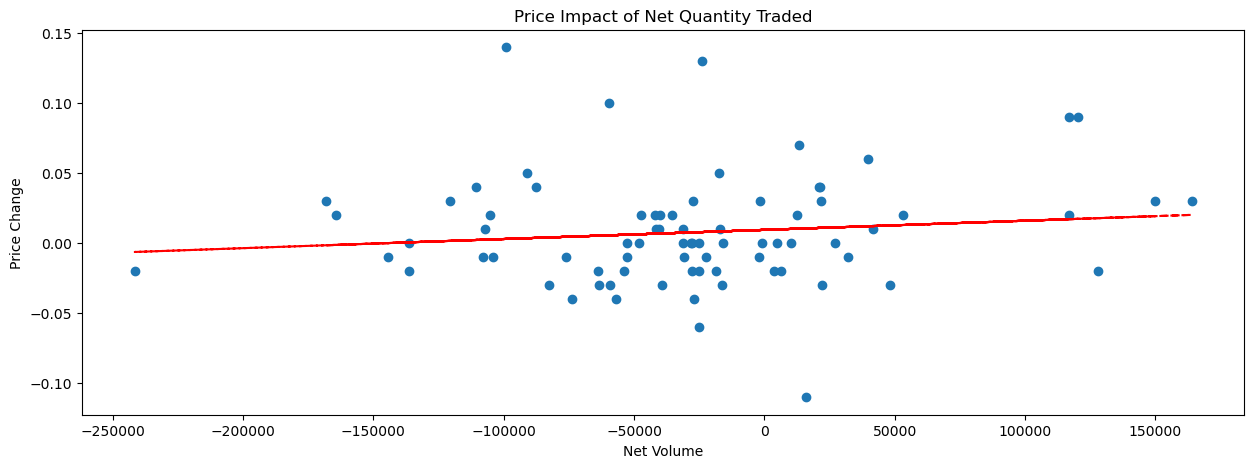

In [28]:
%%py
plt.scatter(qty, dpx)
plt.title('Price Impact of Net Quantity Traded')
plt.xlabel('Net Volume')
plt.ylabel('Price Change')
plt.plot(qty,line,"r--")

# Market Impact

While Kyle's lambda has an elegant theoretical proof, it is not
observed in practice (for large quantities).  Empirical evidence
indicates that impact is sub-linear.

## Market impact components
- **Temporary** impact is defined as the price change between order
  initiation and order completion
- **Permanent** impact includes the reversion that occurs once the
  order has finished - and the pressure has been removed

## Market impact concavity
- Empirical evidence has shown that temporary market impact is
  concave. Impact is large at first, but as the size of the order
  grows, the incremental impact trails off.
- Similarly the impact across time is concave, a large order worked
  over the course of the day has the greatest effect at the beginning
  of the order, and then moves the stock with smaller and smaller
  increments.
- The intuition here is that as the large order moves the price, other
  market participants will arrive to provide liquidity at prices they
  feel are advantageous.

## Market impact scaling
- How much would an order equal to the average daily volume move the
  stock?
- How much does the stock typically move in a given day?
- The impact cost of trading equal to one day's worth of volume will
  be approximately equal to one day's volatility

## Square root law
- Combining these concepts gives the Square Root Law of market impact
$$
I(Q)\sim\sigma\left(\frac{\mid Q\mid}{V}\right)^\frac{1}{2}
$$

where

- $I(Q)$ is the expected impact for a traded quantity $Q$
- $\sigma$ is the stock's daily volatility
- $V$ is the average daily volume of the stock and $\frac{Q}{V}$ is
  the participation rate

## Beyond the square root

- Nothing is so precise, and although the concavity is agreed upon,
  the actual power is debated

$$
I(Q)\sim\sigma\left(\frac{\mid Q\mid}{V}\right)^\delta
$$

where

- $\delta$ typically varies from .4 to .7
- Recent [research][COSTESTIM] indicates 3/5 may be a better exponent
- Exchange, product, country specific?
- Perhaps a bigger question is "is this impact or alpha"?

[COSTESTIM]: http://www.cis.upenn.edu/~mkearns/finread/costestim.pdf

# Trading Costs
- Impact
- Spread
- Exchange Fees
- Stamp Duty

# Tick Size Dynamics

- Tick sizes are the minimum price increment allowed for quotes (but
  not trades) on an exchange
- [Research on HK stocks][HK] shows that decreased tick sizes improve
  market liquidity
- Wide tick sizes force market makers to compete with each other by
  queuing up their orders.
- Tighter tick sizes allow competition on price - resulting in reduced
  margins.
- When tick sizes are too tight, market makers may refuse to
  participate because adverse selection reduces profitability for the
  minimum quote size.

[HK]: https://ro.uow.edu.au/cgi/viewcontent.cgi?article=1185&context=buspapers

## Tick size conventions

- Tick sizes typically vary with stock price in international markets
- Tick sizes on American exchanges have become progressively smaller -
  in an attempt to reduce trading costs.
- Starting with 1/8th of a dollar (0.125), the minimum tick size was
  reduced to 1/16th of a dollar (0.0625) in the 1990s, then to pennies
  in the 2000s.




# Tick Size Pilot Program
- In 2016, the [Tick Size Pilot program][TSPP] placed thinly traded
  stocks into 3 groups to test how **increased** tick sizes would affect
  liquidity and volatility.
- The pilot [ended][TSPPS] on 2018.10.01 with no evidence of improved liquidity or volatility

[TSPP]: https://www.sec.gov/ticksizepilot "Tick Size Pilot program"
[TSPPS]: https://www.barrons.com/articles/sec-tick-size-pilot-program-1536961160 "Tick Size Pilot Program summary"


## Comments on the tick size pilot program
- A [SEC white paper][SEC] had the following to say:

> Specifically, we find that stocks in the Test Groups experience an
> increase in spreads and volatility and a decrease in price
> efficiency, relative to stocks in the Control Group.

- The exchanges and FINRA issued a joint [assessment][] to the SEC

> The Pilot appears to have increased liquidity displayed at the NBBO,
> as well as at other prices throughout the inter-market order book
> Test-Group stocks generally saw less volume, executed in fewer,
> larger transactions with less message traffic, short-term order
> cancellations and quote volatility With respect to market-making
> activity, the Pilot did not appear to increase the number of market
> makers, on average Considering market transparency, the Pilot
> appears to have led to more off-exchange trading. Trading moved away
> from displayed quotes on exchanges with “maker-taker” fee schedules.
    
[SEC]: https://www.sec.gov/dera/staff-papers/white-papers/dera_wp_tick_size-market_quality "SEC tick size white paper"
[assessment]: https://www.sec.gov/files/TICK%20PILOT%20ASSESSMENT%20FINAL%20Aug%202.pdf "Exchange and FINRA joing assessment to SEC"

# Intelligent Ticks
- Instead of creating a fixed tick size based on security price, the
  trading dynamics of the security should be considered
- NASDAQ's [proposal][NASDAQ] is to have an 'Intelligent Tick' methodology where:
  + Stocks would trade in one of **six increments**: 0.005, 0.01,
    0.02, 0.05, 0.10, and 0.25.
  + Stocks would be categorized based upon their **duration weighted
    average quoted spread** over the measurement period.
  + Stocks spreads would not widen under this proposal; rather stocks
    would be assigned the **next smallest increment** by quoted spread
    (e.g., a stock with average spread of 0.12, would be in the 0.10
    increment category).
  + **Listing exchanges would administer the tick regime**,
    calculating and calibrating quoted spreads, determining applicable
    increments, and publishing stock lists.
  
[NASDAQ]: https://www.nasdaq.com/articles/why-intelligent-ticks-make-sense-2020-01-09 "NASDAQ's Intelligent tick proposal"

# Average Daily Volume as a function of Spread and of Price
- Stocks with prices less than one dollar can be quoted with sub-penny
  increments
- Exclude test stocks with symbols like *.T
- Tight spreads are correlated with high average daily volumes


In [29]:
dailystats:{[]select sprdbps:avg spread,queue:avg .5*bsize+asize,adv:avg price, avg price%size by sym from daily}
s:h (dailystats;`)

In [30]:
.pykx.set[`s] .pykx.topd update logadv:log adv,logqueue:log queue from select from s where not sym like "*.T" 

## ADV as a function of sprdbps and price

[Text(311.1689631198435, 0.00013094280088023368, 'AAPL'),
 Text(2067.3925743965565, 0.00047651189188147085, 'AMZN'),
 Text(215.68876011884706, 0.00021852085265943605, 'BABA'),
 Text(91.48855869499548, 0.0001092976103555422, 'BIL'),
 Text(335769.9763075732, 0.0008506248514584393, 'BRK.A'),
 Text(285.59241576489626, 9.405807001836345e-05, 'DIA'),
 Text(1461.752532835087, 0.0006883364009785386, 'GOOG'),
 Text(226.55178860073974, 5.36101505137002e-05, 'QQQ'),
 Text(327.4174741590428, 3.727404439556282e-05, 'SPY'),
 Text(793.026692454679, 0.000997088719728948, 'TSLA')]

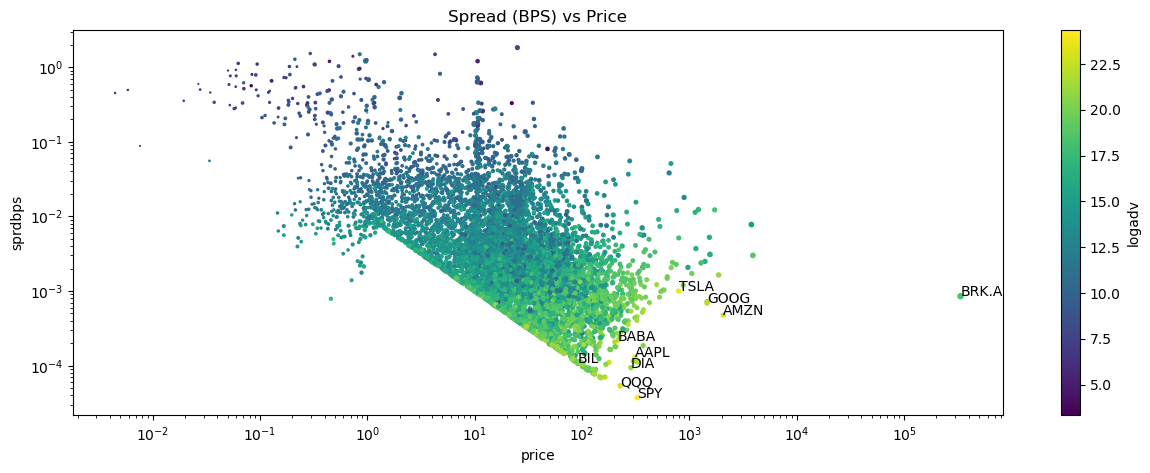

In [31]:
%%py
ax=s.plot.scatter(x='price',y='sprdbps',c='logadv',s='logqueue',
 sharex=False,logx=True,logy=True,colormap='viridis',title='Spread (BPS) vs Price')
tickers=['BRK.A','AAPL','AMZN','GOOG','TSLA','BABA','SPY','QQQ','DIA','BIL']
[ax.annotate(k,v) for k,v in s[s.index.isin(tickers)][['price','sprdbps']].iterrows()]

# Optimal Tick Sizes
- [Robert and Rosenbaum][RANDR] introduced the concept of "uncertainty
  zones"

[RANDR]: https://quantreg.com/wp-content/uploads/2019/04/Robert_Rosenbaum_2009.pdf "Robert and Rosenbaum (2009)"

## Uncertainty zones
- Uncertainty zones exist around the mid price in "large tick assets"
  &mdash; preventing prices from jumping between ticks until the
  unobserved price exits the zone

![Uncertanty Zones](https://www.researchgate.net/profile/Khalil-Dayri/publication/230569014/figure/fig1/AS:669006230982668@1536514923480/The-model-with-uncertainty-zones-example-of-sample-path-The-efficient-price-is-drawn-in.png)

## Uncertainty zone calculation
- Uncertainty zone size can be summarized with a single parameter $\hat{\eta}_{a,t}$:
$$
\hat{\eta}_{a,t} = \frac{N^{(c)}_{a,t}}{2N^{(a)}_{a,t}}
$$

where $N^{(c)}_{a,t}$ represents the number of continuations (price
changes by one tick $a$ in the same direction for a given time $t$)
and $N^{(a)}_{a,t}$ represents the number of alternations (price
changes by one tick $a$ in opposite direction for a given time $t$)

## Optimal tick size definition and [associated risks][YAMAMOTO]
- $\eta < 1/2$ represents a stock whose tick size is too large &mdash;
  resulting in mean-reverting prices, and increased non-execution
  risk, but decreased picking-off risk
- $\eta > 1/2$ represents a stock whose tick size is too small &mdash;
  resulting in decreased non-execution risk but increased picking-off
  risk
- $\eta = 1/2$ is optimal

[YAMAMOTO]: https://doi.org/10.1016/j.pacfin.2019.101261 "Yamamoto 2020"

## Determining optimal tick sizes
- [Dayri and Rosenbaum (2012)][DANDR] offer a methodology to determine
  the optimal tick size for an asset

> We consider that a tick value is optimal if:
> - The (average) ex post cost of a limit order is equal to the (average) ex post cost of a market order, both of them equal to zero.
> - The spread is stable and close to one tick.

- Large Tick Assets: By starting with a stock that has a stable spread
  at one tick, decrease the tick size until $\eta = 1/2$ and the
  spread remains close to one tick
- Small Tick Assets: Increase the tick size until the stock becomes a
  Large Tick Asset, then follow the process for Large Tick Assets

[DANDR]: https://doi.org/10.48550/arXiv.1207.6325 "Dayri and Rosenbaum (2012)"

## Implementation of $\eta$ calculation

In [32]:
/ split implementation into two functions (to demonstrate the calculation)
xtca:{[k;x]          / return (x;ticks;continuations/alternations)
 x:"j"$x%k;          / price in ticks
 x@:where differ x;  / remove 0-tick trades
 t:deltas[0N;x];     / compute # ticks between trades
 d:differ signum t;  / find location of direction changes
 a:d*at:abs t;       / preliminary alternations 
 c:(0|a-1)+at*not d; / continuations include any alternation > 1 tick
 a&:1;               / alternations can only be one tick
 (x;t;c;a)}

eta:{[c;a].5*sum[c]%sum[a]}

- A list can be passed to a function as individual parameters using
  the ``.`` operator instead of the implicit (or explicit) ``@``
  operator


In [33]:
/ example 
x:1 2 2.5 3 6 2 1 2 3 2 1 4 0
`x`ticks`continuations`alternations!xtca[1;x]
eta . -2#xtca[1;x]

x            | 1 2 3 6 2  1  2 3 2  1  4 0 
ticks        |   1 1 3 -4 -1 1 1 -1 -1 3 -4
continuations|   0 1 3 3  1  0 1 0  1  2 3 
alternations |   1 0 0 1  0  1 0 1  0  1 1 
1.25


## Computing $\eta$ on the kdb+ server
- We can pass multiple local functions through to the kdb+ database by
  passing them as arguments to a main function


In [34]:
etas:{[ef;dts;s]
 t:select date,sym,price from trade where date in dts, sym in s, null cond;
 t:select eta:ef price by date, sym from t;
 t:select avg eta by sym from t;
 t}
`eta xasc h(etas[eta . -2#xtca[.005]::];2020.02.01 + til 29;`GE`BAC`MS`AAPL`TSLA`BRK.A)

sym  | eta      
-----| ---------
GE   | 0.1539696
BAC  | 0.2200598
MS   | 0.565602 
AAPL | 3.125591 
TSLA | 39.39133 
BRK.A| 40870.55 


# Reg NMS Changes

To increase liquidity, transparency and affordability for retail
investors, the SEC introduced changes to round/odd-lot sizes Rule
603(b)/600(b), access fees Rule 610, and tick sizes Rule 612.

While the round-lot changes has been [implemented][], the other two
have been delayed.

[implemented]: https://flextrade.com/resources/round-lots-odd-lots-push-forward-while-sec-delays-tick-size-and-access-fees/
"Round Lot Implementation"


## Rule 603(b) and 600(b) (round-lot and odd-lot)
Reg NMS stocks will have [round lot][] definitions changed
semi-annually based on their one-month average primary-listing closing
price.  November 2025.

| Min Price | Max Price | Lot Size |
|----------:|----------:|---------:|
|         0 |       250 |      100 |
|    250.01 |     1,000 |       40 |
|  1,000.01 |    10,000 |       10 |
| 10,000.01 |           |        1 |

Primary-listing average closing prices will be evaluated based on the
following calendar.

| Assignment Month | Evaluation Period |
|------------------|-------------------|
| May              | March             |
| September        | November          |
|                  |                   |

SIPs are now required to disseminate sizes in shares (not lots)
rounded down to the nearest lot when transmitting to the consolidated
tape. (A and B).

[round lot]: https://www.nasdaqtrader.com/TraderNews.aspx?id=UTP2025-10 "Round Lots"



## Rule 610 (access fee)

Reg NMS stocks with prices at or above \\$1 will have access fees
lowered from \\$0.003 to \\$0.001. Reg NMS stocks with prices below
\\$1 will have access fees lowered from 30 bps (0.30%) to 10 bps
(0.10%). November 2025 [delayed][] until November 2026.

|   Price |        Current Fee |            New Fee |
|--------:|-------------------:|-------------------:|
|  < \\$1 |     30 bps (0.30%) |     10 bps (0.10%) |
| >= \\$1 | \\$0.003 (30 mils) | \\$0.001 (10 mils) |

The requirement for fees/rebates to be determinable at time of trade
was delayed until February 2026.

[delayed]: 
https://www.sec.gov/newsroom/press-releases/2025-130-sec-issues-exemptive-order-regarding-compliance-certain-rules-under-regulation-nms
"Access Fees Delay"


## Rule 612 (tick size)
Reg NMS stocks with prices at or above \\$1 and time-weighted average
quoted spread (TWAQS) < \\$0.015 over a 3-month evaluation period will
have their tick size lowered to \\$0.005. Reg NMS stocks with prices
lower than \\$1 already have tick sizes of \\$0.0001. November 2025
[delayed][] until November 2026.

|   Price | 3-Month TWAQS | Tick Size |
|--------:|--------------:|----------:|
| <  \\$1 |               | \\$0.0001 |
| >= \\$1 |   <  \\$0.015 | \\$0.0050 |
| >= \\$1 |   >= \\$0.015 | \\$0.0100 |

[delayed]: 
https://www.sec.gov/newsroom/press-releases/2025-130-sec-issues-exemptive-order-regarding-compliance-certain-rules-under-regulation-nms
"Tick Size Delay"



# Window Join
- The window join `wj` operator performs custom function on the data
  between two points in time.
- Similar to `aj` and `asof`, it uses the `bin` operator on the time
  column.
- All join keys except the last will be used for exact matches (just
  like `aj`)
- The last join key will be used with the `bin` operator on the
  remaining rows to find the most recent record (again, just like
  `aj`)
- But unlike `aj`, the attribute on the `` `sym`` column must be ``
  `p`` and not `` `g``.  The operator, therefore, works on HDBs but
  not RDBs


## Window join example
- Suppose we want to benchmark the performance of each trade
- We can use the `wj` operator to find the vwap and last price over the next 10 minutes

In [35]:
taq:update ntnl:price*size,turn:size,mid10min:mid from taq
taq:wj[0D00 0D00:10+\:taq`time;`time;taq;(taq;(sum;`ntnl);(sum;`turn);(last;`mid10min))]
taq:update vwap10min:ntnl%turn from taq
select time,size,price,mid10min,vwap10min from taq

time                 size price mid10min vwap10min
--------------------------------------------------
0D09:30:01.935330666 153  34.09 34.155   34.18264 
0D09:30:02.739572077 100  34.07 34.165   34.18246 
0D09:30:05.610707976 114  34.1  34.165   34.18246 
0D09:30:10.679172558 100  34.07 34.165   34.18229 
0D09:30:10.684007131 100  34.07 34.165   34.1823  
0D09:30:10.684596467 262  34.07 34.165   34.18231 
0D09:30:10.685644990 100  34.08 34.165   34.18232 
0D09:30:10.685658125 400  34.07 34.165   34.18233 
0D09:30:10.695135414 100  34.07 34.165   34.18236 
0D09:30:10.695646620 100  34.07 34.165   34.18236 
0D09:30:11.645370559 100  34.09 34.165   34.18237 
0D09:30:15.102621868 100  34.08 34.175   34.18229 
0D09:30:15.103393374 147  34.08 34.175   34.1823  
0D09:30:15.103877109 147  34.08 34.175   34.1823  
0D09:30:15.425187088 200  34.08 34.185   34.18231 
..


## Precise TWAP example
- Previous examples of calculating TWAP didn't generate windows if
  there were no quotes and threw away the first entry within each
  window
- The following example pre-generates all time windows and then uses
  `wj` to find all quotes that lie within each window


### Generate a 'rack'

- Using `cross` we can generate a 'rack' of all dates, syms and times
- Think of a 'rack' as something that has hooks on which you can hang
  things


In [36]:
rng:{[w;s;e]s+w*til floor(e-s)%w}
w:0D01                          / minutely windows
r:select distinct date,sym from n
show r:r cross ([]otime:rng[w;0D;1D])   / rack of all time


date       sym otime               
-----------------------------------
2020.02.05 BAC 0D00:00:00.000000000
2020.02.05 BAC 0D01:00:00.000000000
2020.02.05 BAC 0D02:00:00.000000000
2020.02.05 BAC 0D03:00:00.000000000
2020.02.05 BAC 0D04:00:00.000000000
2020.02.05 BAC 0D05:00:00.000000000
2020.02.05 BAC 0D06:00:00.000000000
2020.02.05 BAC 0D07:00:00.000000000
2020.02.05 BAC 0D08:00:00.000000000
2020.02.05 BAC 0D09:00:00.000000000
2020.02.05 BAC 0D10:00:00.000000000
2020.02.05 BAC 0D11:00:00.000000000
2020.02.05 BAC 0D12:00:00.000000000
2020.02.05 BAC 0D13:00:00.000000000
2020.02.05 BAC 0D14:00:00.000000000
..


### Allocate each quote
- Add a window closing time `ctime` to be used with `wj`
- Use `wj` window join to allocate each quote time, weighted mid and
  spread


In [38]:
r:update ctime:w+otime from r / add close time
show r:wj[r`otime`ctime;`sym`otime;r](update otime:time from n;(::;`time);(::;`wmid);(::;`sprd))


date       sym otime                ctime                time                                                                                                                                        ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
2020.02.05 BAC 0D00:00:00.000000000 0D01:00:00.000000000 `timespan$()                                                                                                                                ..
2020.02.05 BAC 0D01:00:00.000000000 0D02:00:00.000000000 `timespan$()                                                                                                                                ..
2020.02.05 BAC 0D02:00:00.000000000 0D03:00:00.000000000 `timespan$()                                                                                                                                ..


2020.02.05 BAC 0D08:00:00.000000000 0D09:00:00.000000000 0D07:59:33.448610050 0D08:00:00.589859634 0D08:00:23.627247647 0D08:00:33.241601333 0D08:01:11.936272247 0D08:01:41.268134430 0D08:01:43.137..
2020.02.05 BAC 0D09:00:00.000000000 0D10:00:00.000000000 0D08:59:42.074019764 0D09:00:20.678710920 0D09:00:21.288455911 0D09:00:34.101218032 0D09:00:58.320463494 0D09:01:09.796291465 0D09:01:32.010..
2020.02.05 BAC 0D10:00:00.000000000 0D11:00:00.000000000 0D09:59:59.988428807 0D10:00:00.000729666 0D10:00:00.020510532 0D10:00:00.063029256 0D10:00:00.063034108 0D10:00:00.063046693 0D10:00:00.063..
2020.02.05 BAC 0D11:00:00.000000000 0D12:00:00.000000000 0D10:59:59.980790697 0D11:00:00.000784725 0D11:00:00.000787910 0D11:00:00.000820226 0D11:00:00.000820226 0D11:00:00.000836626 0D11:00:00.000..
2020.02.05 BAC 0D12:00:00.000000000 0D13:00:00.000000000 0D11:59:59.746134755 0D12:00:00.011192343 0D12:00:00.054901114 0D12:00:00.054911536 0D12:00:00.092932920 0D12:00:00.093067179 0D12:00:00.093..


2020.02.05 BAC 0D13:00:00.000000000 0D14:00:00.000000000 0D12:59:59.930297457 0D13:00:00.012426166 0D13:00:00.012466215 0D13:00:00.012510950 0D13:00:00.012859340 0D13:00:00.013153978 0D13:00:00.013..
2020.02.05 BAC 0D14:00:00.000000000 0D15:00:00.000000000 0D13:59:59.866300732 0D14:00:00.025434155 0D14:00:00.025517586 0D14:00:00.025529203 0D14:00:00.025595775 0D14:00:00.025606808 0D14:00:00.025..
..


### Compute the duration
- Append the window closing time `ctm`
- Max the first quote `tm[0]` time with the window opening time `otm`
  (`wj` includes the *prevailing* quote in each window)
- Computing the time differences with `deltas` and throw away the
  first entry (ultimately shifting the durations forward)
  

In [39]:
durnf:{[otm;ctm;tm] 1 _ deltas @[;0;|;otm] tm,ctm}
r:update durn:durnf'[otime;ctime;time],nq:count each time from r
select date,sym,time:otime,durn wavg' wmid,durn wavg' sprd,nq from r


date       sym time                 wmid     sprd        nq    
---------------------------------------------------------------
2020.02.05 BAC 0D00:00:00.000000000                      0     
2020.02.05 BAC 0D01:00:00.000000000                      0     
2020.02.05 BAC 0D02:00:00.000000000                      0     
2020.02.05 BAC 0D03:00:00.000000000                      0     
2020.02.05 BAC 0D04:00:00.000000000 33.92144 0.2505381   948   
2020.02.05 BAC 0D05:00:00.000000000 34.07522 0.1181239   129   
2020.02.05 BAC 0D06:00:00.000000000 34.00126 0.1143696   547   
2020.02.05 BAC 0D07:00:00.000000000 33.96933 0.04319685  134   
2020.02.05 BAC 0D08:00:00.000000000 34.09602 0.0340799   542   
2020.02.05 BAC 0D09:00:00.000000000 34.16423 0.02141182  273016
2020.02.05 BAC 0D10:00:00.000000000 34.48654 0.009995618 628827
2020.02.05 BAC 0D11:00:00.000000000 34.64502 0.009992804 298320
2020.02.05 BAC 0D12:00:00.000000000 34.75398 0.009998482 182908
2020.02.05 BAC 0D13:00:00.000000000 34.6

# Trade Markouts
Demonstrates market movements before and after a trade over multiple
time horizons.

- Alpha profiles
- Transaction cost analysis (TCA)
- Counterparty-specific hedging strategies

## What questions can markouts answer?
First we generate a few trades with a (semi) smart alpha strategy
- Perhaps they are our trades
- Perhaps they are trades from a trader within the firm
- Perhaps they are trades from a client

Then we answer a few questions
- How skilled is the trader?
- How fast (slow) is the trader?
- How [im]patient is the trader?
- Are the trades profitable within the first few seconds, minutes,
  hours, days?


## Predicting price moves using z-score

In [41]:
z:{[m;x]
 r:log ratios[first x;x]; / return
 z:m mavg r;    / mean
 z%:m mdev r;    / deviation
 z:(m#0n),m _z; / null-padded z-scores
 z}

In [42]:
t:h(trades;dt;`SPY)

## First attempt (each lag as a manually added new column)
- We can `aj` the market prices 1, 2, 3, 4, 5 seconds, minutes, hours
  or days later


In [43]:
mw:10 / moving window
ns:20 / top n signals
ow:0D00:00:01 / observation window
r:([]time:rng[ow;0D09:30:00;0D16:00:00]) / rack
r:aj[`time;r] t
r:update sig:neg z[mw;price] from r / z-score
r:select[ns;>abs sig] time,sig,side:signum sig,price from r / top n signals
show r

time                 sig       side price   
--------------------------------------------
0D15:56:31.000000000 -1.609281 -1   332.55  
0D15:56:30.000000000 -1.577821 -1   332.53  
0D10:23:48.000000000 -1.575116 -1   331.78  
0D15:56:28.000000000 -1.57461  -1   332.52  
0D15:45:21.000000000 1.548629  1    332.57  
0D15:45:20.000000000 1.440729  1    332.58  
0D15:45:22.000000000 1.433748  1    332.5625
0D15:52:23.000000000 -1.369501 -1   332.3961
0D15:56:27.000000000 -1.293147 -1   332.51  
0D15:56:29.000000000 -1.291827 -1   332.52  
0D15:49:14.000000000 -1.290981 -1   332.73  
0D15:49:15.000000000 -1.285714 -1   332.74  
0D13:02:36.000000000 1.284067  1    331.91  
0D10:23:47.000000000 -1.257935 -1   331.76  
0D15:51:41.000000000 1.25724   1    332.35  
..


In [44]:
s:r
s:aj[`time;s] select time-1*w,price1:price from t
s:aj[`time;s] select time-2*w,price2:price from t
s:aj[`time;s] select time-3*w,price3:price from t
s

time                 sig       side price    price1  price2  price3 
--------------------------------------------------------------------
0D15:56:31.000000000 -1.609281 -1   332.55   332.84  332.84  332.84 
0D15:56:30.000000000 -1.577821 -1   332.53   332.84  332.84  332.84 
0D10:23:48.000000000 -1.575116 -1   331.78   331.76  332.045 331.845
0D15:56:28.000000000 -1.57461  -1   332.52   332.84  332.84  332.84 
0D15:45:21.000000000 1.548629  1    332.57   332.84  332.84  332.84 
0D15:45:20.000000000 1.440729  1    332.58   332.84  332.84  332.84 
0D15:45:22.000000000 1.433748  1    332.5625 332.84  332.84  332.84 
0D15:52:23.000000000 -1.369501 -1   332.3961 332.84  332.84  332.84 
0D15:56:27.000000000 -1.293147 -1   332.51   332.84  332.84  332.84 
0D15:56:29.000000000 -1.291827 -1   332.52   332.84  332.84  332.84 
0D15:49:14.000000000 -1.290981 -1   332.73   332.84  332.84  332.84 
0D15:49:15.000000000 -1.285714 -1   332.74   332.84  332.84  332.84 
0D13:02:36.000000000 1.284067  1  

- And then compute 1, 2, 3, 4, 5 second, minute, hour returns

In [45]:
s:update ret1:side*log price1%price from s
s:update ret2:side*log price2%price from s
s:update ret3:side*log price3%price from s
s

time                 sig       side price    price1  price2  price3  ret1          ret2          ret3         
--------------------------------------------------------------------------------------------------------------
0D15:56:31.000000000 -1.609281 -1   332.55   332.84  332.84  332.84  -0.0008716693 -0.0008716693 -0.0008716693
0D15:56:30.000000000 -1.577821 -1   332.53   332.84  332.84  332.84  -0.0009318124 -0.0009318124 -0.0009318124
0D10:23:48.000000000 -1.575116 -1   331.78   331.76  332.045 331.845 6.028273e-05  -0.0007984032 -0.0001958938
0D15:56:28.000000000 -1.57461  -1   332.52   332.84  332.84  332.84  -0.0009618854 -0.0009618854 -0.0009618854
0D15:45:21.000000000 1.548629  1    332.57   332.84  332.84  332.84  0.0008115298  0.0008115298  0.0008115298 
0D15:45:20.000000000 1.440729  1    332.58   332.84  332.84  332.84  0.0007814614  0.0007814614  0.0007814614 
0D15:45:22.000000000 1.433748  1    332.5625 332.84  332.84  332.84  0.0008340817  0.0008340817  0.0008340817 
0

## Second attempt (as a programatically added new column)
- But who likes copy/paste code?
- Another approach is to write a function that iteratively appends
  lagged returns
- But there are problems.  How do we select from a table with minus
  signs in the column name?
- Is it easy to change lags from minutes to seconds?

In [46]:
laggedreturn:{[w;s;lag]
 s:aj[`time;s] select time-w*lag,lprice:price from t;
 s:update ret:side*log lprice%price from s;
 s:(`lprice`ret!`$("price";"ret"),\:string lag) xcol s;
 s}

In [47]:
show r:r laggedreturn[ow]/ rng[1;neg mw;mw]


time                 sig       side price    price-10 ret-10       price-9  ret-9        price-8  ret-8        price-7  ret-7        price-6  ret-6        price-5  ret-5        price-4  ret-4      ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
0D15:56:31.000000000 -1.609281 -1   332.55   332.43   0.0003609131 332.4499 0.0003010527 332.45   0.0003007519 332.46   0.0002706726 332.48   0.0002105168 332.49   0.0001804403 332.51   0.000120289..
0D15:56:30.000000000 -1.577821 -1   332.53   332.42   0.0003308519 332.43   0.00030077   332.4499 0.0002409095 332.45   0.0002406087 332.46   0.0002105295 332.48   0.0001503737 332.49   0.000120297..
0D10:23:48.000000000 -1.575116 -1   331.78   331.64   0.0004220554 331.655  0.0003768267 331.67   0.0003316    331.69   0.0002713009 331.72   0.0001808591 331.74   0.0001205691 331.74   0.000120569..


## Markout plot
- Unpivot the return columns
- compute average and standard deviation of each lag

In [48]:
unpivot:{ungroup (x!(key;value)@\:) each y}
c:`$"ret",/:string rng[1;neg mw;mw]
s:select "I"$3_/:string lag, ret from  unpivot[`lag`ret] c#r
.pykx.set[`df] .pykx.topd df:select avg ret,err:sdev ret by lag from s

0D15:56:27.000000000 -1.293147 -1   332.51   332.41   0.0003007881 332.41   0.0003007881 332.4201 0.0002704044 332.42   0.0002707052 332.43   0.0002406232 332.4499 0.0001807628 332.45   0.000180462..
0D15:56:29.000000000 -1.291827 -1   332.52   332.4201 0.0003004782 332.42   0.000300779  332.43   0.000270697  332.4499 0.0002108366 332.45   0.0002105358 332.46   0.0001804566 332.48   0.000120300..
0D15:49:14.000000000 -1.290981 -1   332.73   332.63   0.0003005892 332.65   0.0002404641 332.65   0.0002404641 332.66   0.0002104029 332.66   0.0002104029 332.68   0.0001502833 332.69   0.000120224..
0D15:49:15.000000000 -1.285714 -1   332.74   332.65   0.000270518  332.65   0.000270518  332.66   0.0002404569 332.66   0.0002404569 332.68   0.0001803372 332.69   0.0001502788 332.7    0.000120221..
0D13:02:36.000000000 1.284067  1    331.91   331.96   0.0001506319 331.9559 0.0001382809 331.95   0.0001205073 331.95   0.0001205073 331.95   0.0001205073 331.94   9.038186e-05 331.93   6.025548e-0..


0D10:23:47.000000000 -1.257935 -1   331.76   331.64   0.0003617727 331.64   0.0003617727 331.655  0.0003165439 331.67   0.0002713172 331.69   0.0002110182 331.72   0.0001205764 331.74   6.028636e-0..
0D15:51:41.000000000 1.25724   1    332.35   332.42   0.0002105992 332.415  0.0001955578 332.415  0.0001955578 332.4    0.0001504325 332.39   0.0001203478 332.385  0.0001053051 332.37   6.017571e-0..
..


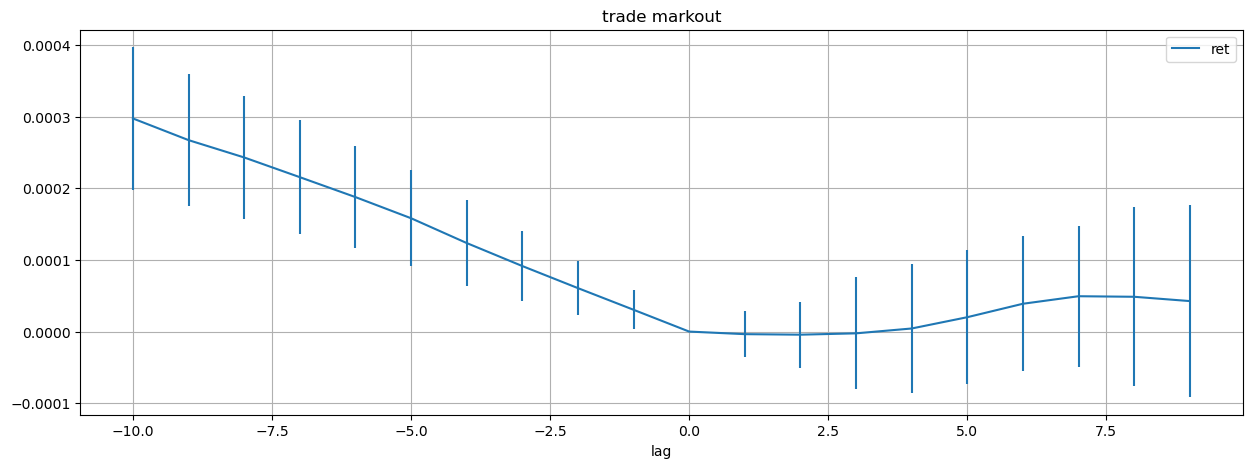

In [49]:
%%py
df.plot(title='trade markout',yerr='err')
plt.grid()

## Third attempt (as a single pivoted new column)
- An alternative is to compute all the lagged returns in a single shot
- Use long and skinny tables
- First `cross` the trades table with a table of lags and update trade
  time
- Then we only need a **single** `aj` and compute returns
- There will be no need to 'unpivot' the resulting table
- This will be implemented on the homework assignment

